# Imputing algorithms

Missing data is a common problem in math modeling and machine learning. Machine Learning models cannot inherently work with missing data, and hence it becomes imperative to learn how to properly decide between different kinds of imputation techniques to achieve the best possible model for the use case.

3 categories of missing data:
- Missing Completely at Random (MCAR) - Implies the missingness of a  field is completely random, and that we probably cannot predict that value from any other value in the data.
- Missing at Random (MAR) - Implies that the missingness of a field can be explained by the values in other columns, but not from that column.
- Missing NOT at Random (MNAR) - Implies whether there was a reason why the respondent didn’t fill up that field, and hence that data is not missing at random. For example, if someone is obese, they are less likely to disclose their weight.

In [1]:
from datetime import datetime as dt
from functools import reduce

def simulate_nan(X, nan_rate):
    '''(np.array, number) -> {str: np.array or number}
    
    Preconditions:
    1. np.isnan(X_complete).any() == False
    2. 0 <= nan_rate <= 1
    
    Return the dictionary with four keys where: 
    - Key 'X' stores a np.array where some of the entries in X 
      are replaced with np.nan based on nan_rate specified.
    - Key 'C' stores a np.array where each entry is False if the
      corresponding entry in the key 'X''s np.array is np.nan, and True
      otherwise.
    - Key 'nan_rate' stores nan_rate specified.
    - Key 'nan_rate_actual' stores the actual proportion of np.nan
      in the key 'X''s np.array.
    '''
    
    # Create C matrix; entry is False if missing, and True if observed
    X_complete = X.copy()
    nr, nc = X_complete.shape
    C = np.random.random(nr * nc).reshape(nr, nc) > nan_rate
    
    # Check for which i's we have all components become missing
    checker = np.where(sum(C.T) == 0)[0]
    if len(checker) == 0:
        # Every X_i has at least one component that is observed,
        # which is what we want
        X_complete[C == False] = np.nan
    else:
        # Otherwise, randomly "revive" some components in such X_i's
        for index in checker:
            reviving_components = np.random.choice(
                nc, 
                int(np.ceil(nc * np.random.random())), 
                replace = False
            )
            C[index, np.ix_(reviving_components)] = True
        X_complete[C == False] = np.nan
    
    result = {
        'X': X_complete,
        'C': C,
        'nan_rate': nan_rate,
        'nan_rate_actual': np.sum(C == False) / (nr * nc)
    }
    
    return result

## MICE

MICE stands for Multivariate Imputation By Chained Equations algorithm, a technique by which we can effortlessly impute missing values in a dataset by looking at data from other columns and trying to estimate the best prediction for each missing value. 

MICE algorithm is an iterative imputation method. 


In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df = pd.DataFrame({
    'age': [25, 27, 29, 31, 33, np.nan, 37, 39, 41, np.nan, 45],
    'experience': [np.nan, 3, 5, 7, 9, 11, 13, 16, np.nan, 19, 21],
    'salary': [50, np.nan, 110, 140, 170, 200, 230, 260, np.nan, 320, 350],
    'Personal loan': [1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0], 
})
df

,age,experience,salary,Personal loan
0,25.0,NaN,50.0,1
1,27.0,3.0,NaN,1
2,29.0,5.0,110.0,0
3,31.0,7.0,140.0,0
4,33.0,9.0,170.0,1
5,NaN,11.0,200.0,0
6,37.0,13.0,230.0,0
7,39.0,16.0,260.0,1
8,41.0,NaN,NaN,0
9,NaN,19.0,320.0,1


In [3]:
X = df.drop('Personal loan', 1)
Y = df['Personal loan']

X

,age,experience,salary
0,25.0,NaN,50.0
1,27.0,3.0,NaN
2,29.0,5.0,110.0
3,31.0,7.0,140.0
4,33.0,9.0,170.0
5,NaN,11.0,200.0
6,37.0,13.0,230.0
7,39.0,16.0,260.0
8,41.0,NaN,NaN
9,NaN,19.0,320.0


In [4]:
X.corr()

,age,experience,salary
age,1.000000,0.998446,1.00000
experience,0.998446,1.000000,0.99814
salary,1.000000,0.998140,1.00000


As we see here, the values we got are either 1 or very close to 1, so we can use linear regression to impute null values. 

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

lr = LinearRegression()
imp = IterativeImputer(estimator=lr, verbose=0, max_iter=30, tol=1e-10, imputation_order='roman')

imp.fit_transform(X_train)

X_test

,age,experience,salary
8,41.0,NaN,NaN
9,NaN,19.0,320.0
10,45.0,21.0,350.0


In [6]:
imp.transform(X_test)

array([[ 41.        ,  17.57142857, 290.        ],
       [ 43.        ,  19.        , 320.        ],
       [ 45.        ,  21.        , 350.        ]])

## missForest

**MissForest** is a random forest imputation algorithm for missing data. 

It initially imputes all missing data using the mean/mode, then for each variable with missing values, MissForest fits a random forest on the observed part and then predicts the missing part. This process of training and predicting repeats in an iterative process until a stopping criterion is met, or a maximum number of user-specified iterations is reached.

**Advantages**:
- Can be applied to mixed data types (missings in numeric & categorical variables)
- No pre-processing required (no dummy-coding, standardization, data splitting, etc.)
- No assumptions required (aside from the normal assumption of being MAR/MCAR)
- Robust to noisy data, as random forests effectively have build-in feature selection. Methods like KNN imputation will have poor predictions in datasets with weak & non-informative predictors, whereas missForest() will make little to no use of these features
- Non-parametric: makes no assumptions about the relationship between the features, unlike MICE which assumes linearity
- Excellent predictive power
- Can leverage non-linear and interaction effects between features to improve imputation accuracy
- Works with high dimensionality data (p≫n)

**Disadvantages**:
- Imputation time, which increases with the number of observations, predictors and number of predictors containing missing values
- It inherits the same lack of interpretability of random forests
- It is an algorithm, not a model object you can store somewhere. This means it has to run each time missing data has to be imputed, which could be problematic in some production environments.

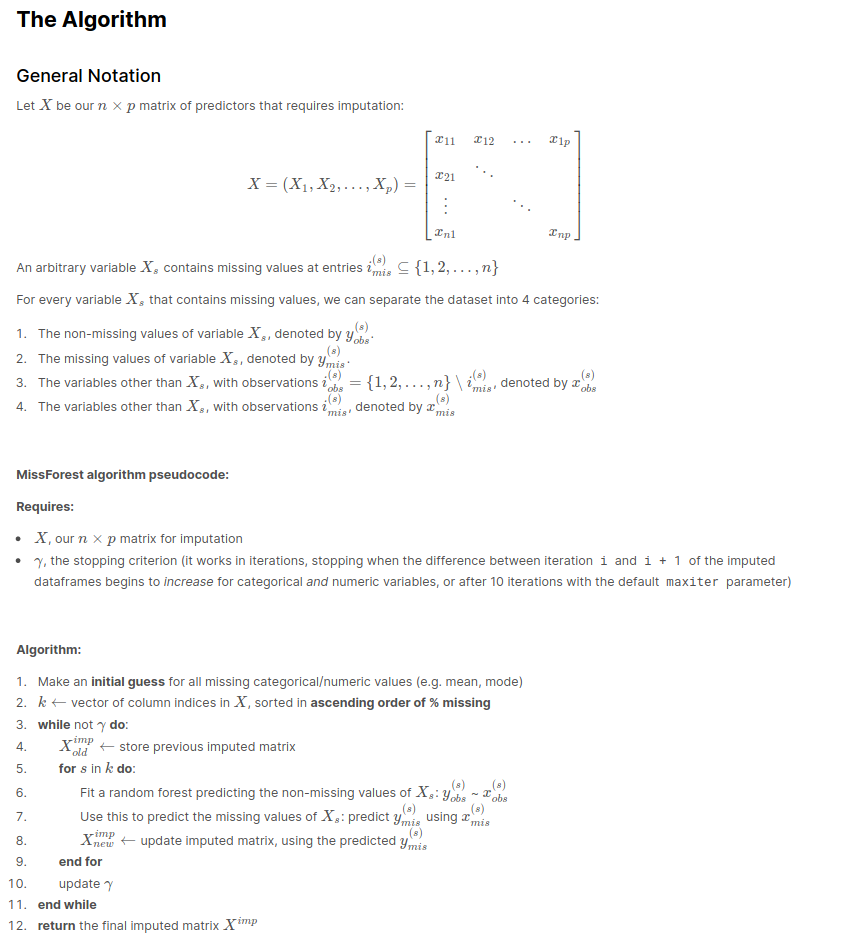


In [7]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

class RandomForest:
    """integrated class for RandomForestRegressor and RandomForestClassifier"""
    def __init__(self, params):
        """initialize two random forest models and job parameters"""
        self._unpack(params)
        self.reg = RandomForestRegressor(criterion='mse', **self.params)
        self.clf = RandomForestClassifier(criterion='gini', **self.params, class_weight=self.cw)
        self.done = False
        self.err = None

    def _unpack(self, params):
        """Unpack params to set parameters for both random forests"""
        params = dict(params)
        self.cw = params.pop('class_weight')
        self.params = params

    def fit_predict(self, X_train, y_train, X, vt):
        """dynamically decide model and returns prediction"""
        rf = None
        y = None
        try:
            if vt == 1:
                rf = self.reg 
            else:
                rf = self.clf 
            rf.fit(X_train, y_train)
            y = rf.predict(X)
            self.done = True
        except Exception as e:
            print(e)
            self.err = e

        return y

In [8]:
from abc import ABC, abstractmethod
from enum import Enum
import numpy as np
import math
import time

def isnan(x):
    """return boolean for checking if value is nan"""
    if isinstance(x, (float, np.floating)):
        return np.isnan(x)
    else:
        return x == 'nan'

def mode(x):
    """return the mode of a list"""
    count = defaultdict(int)
    for item in x:
        count[item] += 1
    return max(count, key=count.get)

class InitialGuessOptions(Enum):
    MEAN    = "mean"
    ZERO    = "zero"

class MissForestImputation(ABC):
    """Private class, MissForest imputation class"""
    def __init__(self, max_iter, init_imp, vart_):
        self.max_iter = max_iter
        self.init_imp = init_imp
        self.vart_ = vart_
        self.vari = None
        self.misi = None
        self.obsi = None
        self.previous_diff        = None
        self.matrix_for_impute    = None
        self.initial_guess_matrix = None
        self.previous_iter_matrix = None
        self.cur_iter_matrix      = None
        self.result_matrix        = None

    @abstractmethod
    def miss_forest_imputation(self, matrix_for_impute):
        pass

    def check_converge(self):
        p = len(self.vart_)
        numi = [i for i in range(p) if self.vart_[i] == 1]
        cati = [i for i in range(p) if self.vart_[i] == 0]
        cur_diff = [None, None]
        # difference of numerical
        if len(numi) > 0:
            X_old_num = self.previous_iter_matrix[:, numi]
            X_new_num = self.cur_iter_matrix[:, numi]
            square_diff_sum = np.sum((X_old_num - X_new_num) ** 2)
            square_sum = np.sum((X_new_num) ** 2)
            cur_diff[0] = square_diff_sum / square_sum
        # difference of categorical
        if len(cati) > 0:
            X_old_cat = self.previous_iter_matrix[:, cati]
            X_new_cat = self.cur_iter_matrix[:, cati]
            num_differ = np.sum(X_old_cat != X_new_cat)
            num_mis = sum([self.misi[i] for i in cati])
            cur_diff[1] = num_differ / num_mis
        # skip if first iteration
        if self.previous_diff is None:
            self.previous_diff = cur_diff
            return False
        else:
            # neither of numerical or categorical should degenerate
            for i in range(2):
                if self.previous_diff[i] != None and cur_diff[i] > self.previous_diff[i]:
                    return True
            self.previous_diff = cur_diff
            return False

    def raw_fill(self):
        """imputation preparation, fill missing values with specified values"""
        Xmis = self.matrix_for_impute
        Ximp = np.copy(Xmis)
        n, p = np.shape(Xmis)

        misn = [] # number of missing for each variable
        misi = [] # indices of missing samples for each variable
        obsi = [] # indices of observations for each variable
        for v in range(p):
            vt = self.vart_[v]
            col = Ximp[:, v]
            var_misi = np.where(np.isnan(col))[0]
            var_obsi = np.delete(np.arange(n), var_misi)
            misn.append(len(var_misi))
            misi.append(var_misi)
            obsi.append(var_obsi)
            if vt == 1: # numerical
                if self.init_imp == InitialGuessOptions.MEAN.value:
                    var_mean = np.mean(col[var_obsi])
                    Ximp[var_misi, v] = np.array([var_mean for _ in range(misn[-1])])
                if self.init_imp == InitialGuessOptions.ZERO.value:
                    Ximp[var_misi, v] = np.array([0 for _ in range(misn[-1])])
            else: # categorical
                if self.init_imp == InitialGuessOptions.MEAN.value:
                    var_mode = mode(col[var_obsi].tolist())
                    Ximp[var_misi, v] = np.array([var_mode for _ in range(misn[-1])])
        vari = np.argsort(misn).tolist()
        self.initial_guess_matrix = Ximp
        self.vari = vari
        self.misi = misi
        self.obsi = obsi

In [9]:
class MissForestImputationLocal(MissForestImputation):
    """private class, missforest subclass for local machine"""
    def __init__(self, mf_params, rf_params):
        super().__init__(**mf_params)
        self.params = rf_params

    def miss_forest_imputation(self, matrix_for_impute):
        """impute dataset and return self"""
        self.matrix_for_impute = matrix_for_impute
        self.raw_fill()

        self.previous_iter_matrix = np.copy(self.initial_guess_matrix)
        self.cur_iter_matrix = np.copy(self.initial_guess_matrix)
        cur_iter = 1
        
        while True:
            if cur_iter > self.max_iter:
                self.result_matrix = self.previous_iter_matrix
                return

            for var in self.vari:
                p = len(self.vart_)
                vt = self.vart_[var]
                cur_X = self.cur_iter_matrix
                cur_obsi = self.obsi[var]
                cur_misi = self.misi[var]
                if (len(cur_misi) == 0):
                    continue
                p_train = np.delete(np.arange(p), var)
                X_train = cur_X[cur_obsi, :][:, p_train]
                y_train = cur_X[cur_obsi, :][:, var]
                X_test = cur_X[cur_misi, :][:, p_train]
                rf = RandomForest(self.params)
                imp = rf.fit_predict(X_train, y_train, X_test, vt)
                self.cur_iter_matrix[cur_misi, var] = imp

            if self.check_converge() == True:
                self.result_matrix = self.previous_iter_matrix
                return
            else:
                self.previous_iter_matrix = np.copy(self.cur_iter_matrix)
                cur_iter = cur_iter + 1

In [10]:
InitImpOptions = ['mean', 'zero']
ParallelOptions = ['slurm', 'local']

class MissForest:
    '''MissForest Class

    Parameters
    __________
    NOTE: Parameters are consisted by MissForest parameters, RandomForest 
    parameters, and SLURM parameters. For RandomForest is implemented in 
    scikit-learn, many parameters description will be directly referred to 
    [2], [3], [4] (who also uses scikit-learn)

    max_iter : int, optional (default=10)
        The maximum number of iterations in case the convergence is not 
        achieved.

    init_imp : string (default='mean')
        The mode of initial imputation during the preprocessing:
        - If 'mean', each missing value will be imputed with mean/mode value
        - If 'zero', each missing value will be imputed with zero

    n_estimators : integer, optional (default=100)
        The number of trees in the forest.

    max_depth : integer or None, optional (default=None)
        The maximum depth of the tree. If None, then nodes are expanded until 
        all leaves are pure or until all leaves contain less than 
        min_samples_split samples.

    min_samples_split : int, float, optional (default=2)
        The minimum number of samples required to split an internal node:
        - If int, then consider min_samples_split as the minimum number.
        - If float, then min_samples_split is a fraction and ceil(
        min_samples_split * n_samples) are the minimum number of samples for 
        each split.

    min_samples_leaf : int, float, optional (default=1)
        The minimum number of samples required to be at a leaf node. A split 
        point at any depth will only be considered if it leaves at least 
        min_samples_leaf training samples in each of the left and right 
        branches. This may have the effect of smoothing the model, especially 
        in regression.
        - If int, then consider min_samples_leaf as the minimum number.
        - If float, then min_samples_leaf is a fraction and ceil(
        min_samples_leaf * n_samples) are the minimum number of samples for 
        each node.

    min_weight_fraction_leaf : float, optional (default=0.)
        The minimum weighted fraction of the sum total of weights (of all the 
        input samples) required to be at a leaf node. Samples have equal 
        weight when sample_weight is not provided.

    max_features : int, float, string or None, optional (default='sqrt')
        The number of features to consider when looking for the best split:
        - If int, then consider max_features features at each split.
        - If float, then max_features is a fraction and int(max_features * 
        n_features) features are considered at each split.
        - If 'auto', then max_features=sqrt(n_features).
        - If 'sqrt', then max_features=sqrt(n_features) (same as “auto”).
        - If 'log2', then max_features=log2(n_features).
        - If None, then max_features=n_features.
        Note: the search for a split does not stop until at least one valid 
        partition of the node samples is found, even if 
        it requires to effectively inspect more than max_features features.

    max_leaf_nodes : int or None, optional (default=None)
        Grow trees with max_leaf_nodes in best-first fashion. Best nodes are 
        defined as relative reduction in impurity. If None then unlimited 
        number of leaf nodes.

    min_impurity_decrease : float, optional (default=0.)
        A node will be split if this split induces a decrease of the impurity 
        greater than or equal to this value.

        The weighted impurity decrease equation is the following:

        N_t / N * (impurity - N_t_R / N_t * right_impurity
                            - N_t_L / N_t * left_impurity)
        where N is the total number of samples, N_t is the number of samples 
        at the current node, N_t_L is the number of samples in the left child, 
        and N_t_R is the number of samples in the right child.

        N, N_t, N_t_R and N_t_L all refer to the weighted sum, if 
        sample_weight is passed.

    bootstrap : boolean, optional (default=True)
        Whether bootstrap samples are used when building trees. If False, the 
        whole datset is used to build each tree.

    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator; 
        If RandomState instance, random_state is the random number generator; 
        If None, the random number generator is the RandomState instance used 
        by np.random.

    verbose : int, optional (default=0)
        Controls the verbosity when fitting and predicting.

    warm_start : bool, optional (default=False)
        When set to True, reuse the solution of the previous call to fit and 
        add more estimators to the ensemble, otherwise, just fit a whole new 
        forest. See the Glossary.

    class_weight : dict, list of dicts, “balanced”, “balanced_subsample” or 
    None, optional (default=None)
        Weights associated with classes in the form {class_label: weight}. If 
        not given, all classes are supposed to have weight one. For 
        multi-output problems, a list of dicts can be provided in the same 
        order as the columns of y.

        Note that for multioutput (including multilabel) weights should be 
        defined for each class of every column in its own dict. For example, 
        for four-class multilabel classification weights should be [{0: 1, 1: 
        1}, {0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}] instead of [{1:1}, 
        {2:5}, {3:1}, {4:1}].

        The “balanced” mode uses the values of y to automatically adjust 
        weights inversely proportional to class frequencies in the input data 
        as n_samples / (n_classes * np.bincount(y))

        The “balanced_subsample” mode is the same as “balanced” except that 
        weights are computed based on the bootstrap sample for every tree 
        grown.

        For multi-output, the weights of each column of y will be multiplied.

        Note that these weights will be multiplied with sample_weight (passed 
        through the fit method) if sample_weight is specified.


    n_cores : int, optional (default=1)
        The number of cores to process. If parallel == 'local', then n_cores 
        is exactly the same as n_jobs of Scikit-learn.Setting n_jobs to -1 on 
        local machine will use all available cores. If parallel = 'slurm', 
        each node uses n_cores number of cores, and it is no longer available 
        to be set to -1.

    Attributes
    __________
    var_ : list
        A list having the same length as the number of variables. Its elements 
        are 1, 0, and 1 for numerical, 0 for categorical

    Methods
    _______
    fit_transform(self, Xmis, cat_var=None)：
        return the imputed dataset

        Parameters
        __________
        Xmis : {array-like}, shape (n_samples, n_features)
            Input data, where 'n_samples' is the number of samples and 
            'n_features' is the number of features.

        cat_var : list of ints (default=None)
            Specifying the index of columns of categorical variable.

        Return
        ______
        ximp : {array_like}, shape (n_samples, n_features)
            Acquired after imputing all nan of Xmis.'''
    def __init__(self, max_iter=10, init_imp='mean', n_estimators=100, 
                 max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                 min_weight_fraction_leaf=0.0, max_features='sqrt', 
                 max_leaf_nodes=None, min_impurity_decrease=0.0, 
                 bootstrap=True, random_state=None, verbose=0, 
                 warm_start=False, class_weight=None, n_jobs=1):
        self.max_iter = max_iter
        self.init_imp = init_imp
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.verbose = verbose
        self.warm_start = warm_start
        self.class_weight = class_weight
        self.n_jobs = n_jobs

    def _get_mf_params(self):
        """private method, return parameters of MissForest"""
        return {
            'max_iter' : self.max_iter,
            'init_imp' : self.init_imp,
            'vart_' : self.vart_,
        }

    def _get_rf_params(self):
        """private method, return parameters of RandomForest"""
        return {
            'n_estimators' : self.n_estimators,
            'max_depth' : self.max_depth,
            'min_samples_split' : self.min_samples_split,
            'min_samples_leaf' : self.min_samples_leaf,
            'min_weight_fraction_leaf' : self.min_weight_fraction_leaf,
            'max_features' : self.max_features,
            'max_leaf_nodes' : self.max_leaf_nodes,
            'min_impurity_decrease' : self.min_impurity_decrease,
            'bootstrap' : self.bootstrap,
            'random_state' : self.random_state,
            'verbose' : self.verbose,
            'warm_start' : self.warm_start,
            'class_weight' : self.class_weight,
            'n_jobs' : self.n_jobs,
        }
        

    def _check_inputs(self, Xmis, cat_var):
        """private method, validating all inputs"""
        try:
            n, p = np.shape(Xmis)
            self.vart_ = [1 for _ in range(p)]
        except:
            raise ValueError("Xmis: not a matrix")

        if cat_var == None:
            pass
        elif type(cat_var) != list:
            raise ValueError("cat_var: not a list")
        else:
            for i in cat_var:
                self.vart_[i] = 0
        if type(self.max_iter) != int or self.max_iter < 1:
            raise ValueError("max_iter: not a positive integer")
        if self.init_imp not in InitImpOptions:
            raise ValueError("init_imp: not one of mean, zero, knn")

        return np.array(Xmis)


    def fit_transform(self, Xmis, cat_var=None):
        """return imputed matrix-like data"""
        Xmis = self._check_inputs(Xmis, cat_var)
        mf_params = self._get_mf_params()
        rf_params = self._get_rf_params()
        
        mf = MissForestImputationLocal(mf_params, rf_params)
        mf.miss_forest_imputation(Xmis)

        return mf.result_matrix

#### MissForest test 1

In [11]:
imp = MissForest(max_iter=100)

imp.fit_transform(X)

array([[ 25.  ,   3.86,  50.  ],
       [ 27.  ,   3.  ,  76.1 ],
       [ 29.  ,   5.  , 110.  ],
       [ 31.  ,   7.  , 140.  ],
       [ 33.  ,   9.  , 170.  ],
       [ 33.28,  11.  , 200.  ],
       [ 37.  ,  13.  , 230.  ],
       [ 39.  ,  16.  , 260.  ],
       [ 41.  ,  15.64, 263.9 ],
       [ 43.38,  19.  , 320.  ],
       [ 45.  ,  21.  , 350.  ]])

#### MissForest test 2

In [12]:
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)["data"]
iris_orig = iris.copy()

iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [13]:
# Generate unique lists of random integers
inds1 = list(set(np.random.randint(0, len(iris), 10)))
inds2 = list(set(np.random.randint(0, len(iris), 15)))

# Replace the values at given index position with NaNs
iris['sepal length (cm)'] = [val if i not in inds1 else np.nan for i, val in enumerate(iris['sepal length (cm)'])]
iris['petal width (cm)'] = [val if i not in inds2 else np.nan for i, val in enumerate(iris['petal width (cm)'])]

# Get count of missing values by column
iris.isnull().sum()

sepal length (cm)    10
sepal width (cm)      0
petal length (cm)     0
petal width (cm)     14
dtype: int64

In [14]:
imp = MissForest(max_iter=100)

X = iris
X_imputed = imp.fit_transform(X)

# Add imputed values as columns to the untouched dataset
iris_orig['MF_sepal_length'] = X_imputed[:, 0]
iris_orig['MF_petal_width'] = X_imputed[:, -1]
comparison_df = iris_orig[['sepal length (cm)', 'MF_sepal_length', 'petal width (cm)', 'MF_petal_width']]

# Calculate absolute errors
comparison_df['ABS_ERROR_sepal_length'] = np.abs(comparison_df['sepal length (cm)'] - comparison_df['MF_sepal_length'])
comparison_df['ABS_ERROR_petal_width'] = np.abs(comparison_df['petal width (cm)'] - comparison_df['MF_petal_width'])

# Show only rows where imputation was performed
comparison_df.iloc[sorted([*inds1, *inds2])]

<ipython-input-14-d34fed9e32ff>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df['ABS_ERROR_sepal_length'] = np.abs(comparison_df['sepal length (cm)'] - comparison_df['MF_sepal_length'])


,sepal length (cm),MF_sepal_length,petal width (cm),MF_petal_width,ABS_ERROR_sepal_length,ABS_ERROR_petal_width
2,4.7,4.700000,0.2,0.212000,0.000000,1.200000e-02
20,5.4,5.400000,0.2,0.433000,0.000000,2.330000e-01
31,5.4,5.400000,0.4,0.314500,0.000000,8.550000e-02
32,5.2,5.350300,0.1,0.100000,0.150300,0.000000e+00
35,5.0,4.628500,0.2,0.200000,0.371500,0.000000e+00
36,5.5,5.500000,0.2,0.318100,0.000000,1.181000e-01
45,4.8,4.795000,0.3,0.300000,0.005000,0.000000e+00
46,5.1,5.210333,0.2,0.200000,0.110333,0.000000e+00
52,6.9,6.900000,1.5,1.871000,0.000000,3.710000e-01
66,5.6,5.600000,1.5,1.346000,0.000000,1.540000e-01


## SoftImpute



The function softimpute (original article of Hastie and al.) can be used to impute quantitative data. The function coded here in Python mimics the function softimpute of the R package softImpute. It fits a low-rank matrix approximation to a matrix with missing values via nuclear-norm regularization. The main arguments are the following.

-    X: the data set with missing values (matrix).

-    lambda: the nuclear-norm regularization parameter.

To calibrate the parameter lambda, one may perform cross-validation, coded in the function cv_softimpute which takes in argument the data set with missing values and the length of the grid on which cross-validation is performed.


In [15]:
import numpy as np
from sklearn.utils.extmath import randomized_svd

F32PREC = np.finfo(np.float32).eps

# convergence criterion for softimpute
def converged(x_old, x, mask, thresh):
    x_old_na = x_old[mask]
    x_na = x[mask]
    rmse = np.sqrt(np.sum((x_old_na - x_na) ** 2))
    denom = np.sqrt((x_old_na ** 2).sum())
    
    if denom == 0 or (denom < F32PREC and rmse > F32PREC):
      return False
    else:
      return (rmse / denom) < thresh


def softimpute(x, lamb, maxit = 1000, thresh = 1e-5):
    """
    x should have nan values (the mask is not provided as an argument)
    """
    mask = ~np.isnan(x)
    imp = x.copy()
    imp[~mask] = 0

    for i in range(maxit):
        if x.shape[0]*x.shape[1] > 1e6:
            U, d, V = randomized_svd(imp, n_components = np.minimum(200, x.shape[1]))
        else:
            U, d, V = np.linalg.svd(imp, compute_uv = True, full_matrices=False)
        d_thresh = np.maximum(d - lamb, 0)
        rank = (d_thresh > 0).sum()
        d_thresh = d_thresh[:rank]
        U_thresh = U[:, :rank]
        V_thresh = V[:rank, :]
        D_thresh = np.diag(d_thresh)
        res = np.dot(U_thresh, np.dot(D_thresh, V_thresh))
        if converged(imp, res, mask, thresh):
            break
        imp[~mask] = res[~mask]
        
    return U_thresh, imp


def test_x(x, mask):
    # generate additional missing values
    # such that each row has at least 1 observed value (assuming also x.shape[0] > x.shape[1])
    save_mask = mask.copy()
    for i in range(x.shape[0]):
      idx_obs = np.argwhere(save_mask[i, :] == 1).reshape((-1)) 
      if len(idx_obs) > 0:
          j = np.random.choice(idx_obs, 1)
          save_mask[i, j] = 0
    mmask = np.array(np.random.binomial(np.ones_like(save_mask), save_mask * 0.1), dtype=bool)
    xx = x.copy()
    xx[mmask] = np.nan
    return xx, mmask


def cv_softimpute(x, grid_len = 15, maxit = 1000, thresh = 1e-5):   
    # impute with constant
    mask = ~np.isnan(x)
    x0 = x.copy()
    #x0 = copy.deepcopy(x)
    x0[~mask] = 0
    # svd on x0
    if x.shape[0]*x.shape[1] > 1e6:
        _, d, _ = randomized_svd(x0, n_components = np.minimum(200, x.shape[1]))
    else:
        d = np.linalg.svd(x0, compute_uv=False, full_matrices=False)
    # generate grid for lambda values
    lambda_max = np.max(d)
    lambda_min = 0.001*lambda_max
    grid_lambda = np.exp(np.linspace(np.log(lambda_min), np.log(lambda_max), grid_len).tolist())
  
    cv_error = []
    for lamb in grid_lambda:
        xx, mmask = test_x(x, mask)
        mmask = ~np.isnan(xx)
        _, res = softimpute(xx, lamb, maxit, thresh)
        cv_error.append(np.sqrt(np.nanmean((res.flatten() - x.flatten())**2)))

    return cv_error, grid_lambda

In [16]:
#### Simulation of the data matrix ####

np.random.seed(0)  # fix the seed 

n = 1000 
p = 10 

mean = np.repeat(0, p) 
cov = 0.5 * (np.ones((p,p)) + np.eye(p)) 
x_comp = np.random.multivariate_normal(mean, cov, size = n)

perc_miss = 0.3 # 30% NA

XproduceNA =  simulate_nan(x_comp, nan_rate=perc_miss)
X_miss = XproduceNA['X']

cv_error, grid_lambda = cv_softimpute(X_miss, grid_len=15)
lbda = grid_lambda[np.argmin(cv_error)]
x_soft = softimpute((X_miss), lbda)[1]

X_miss

array([[        nan, -0.76892997, -1.11698285, ..., -0.53519233,
                nan, -0.34159914],
       [        nan,         nan,         nan, ..., -0.31559536,
        -0.71813746,         nan],
       [ 2.3318086 ,  2.42092258,  1.88271154, ...,  2.04937691,
         2.45850206,  2.95614677],
       ...,
       [ 0.44162675,  0.58107933,         nan, ...,         nan,
                nan,         nan],
       [ 0.38553369,         nan,  0.2024161 , ..., -0.43687459,
                nan, -0.44783991],
       [-0.45975537,         nan, -0.36205686, ...,         nan,
        -0.91023799,  1.32259759]])

In [17]:
x_soft

array([[-0.59164756, -0.76892997, -1.11698285, ..., -0.53519233,
        -0.62090806, -0.34159914],
       [-0.23609628, -0.2380513 , -0.24752567, ..., -0.31559536,
        -0.71813746, -0.25113456],
       [ 2.3318086 ,  2.42092258,  1.88271154, ...,  2.04937691,
         2.45850206,  2.95614677],
       ...,
       [ 0.44162675,  0.58107933,  0.62049788, ...,  0.62963269,
         0.621117  ,  0.62954466],
       [ 0.38553369,  0.05657117,  0.2024161 , ..., -0.43687459,
         0.05888138, -0.44783991],
       [-0.45975537, -0.02902073, -0.36205686, ..., -0.03061999,
        -0.91023799,  1.32259759]])

## EM/EMB

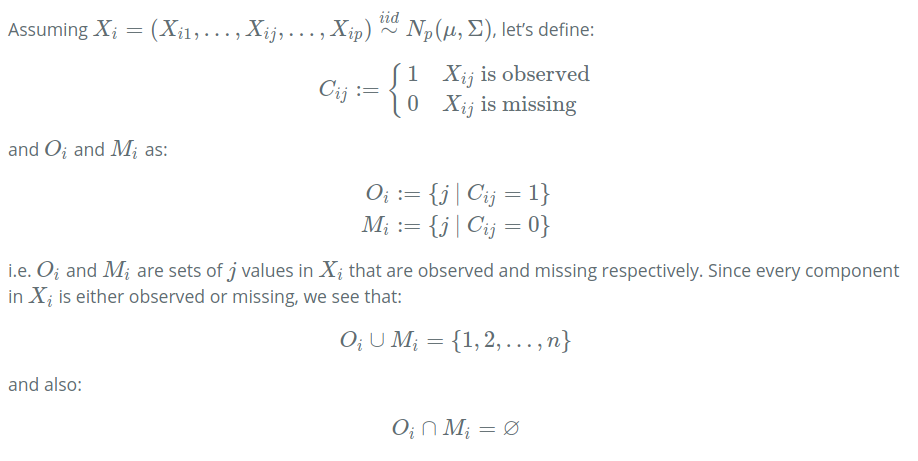

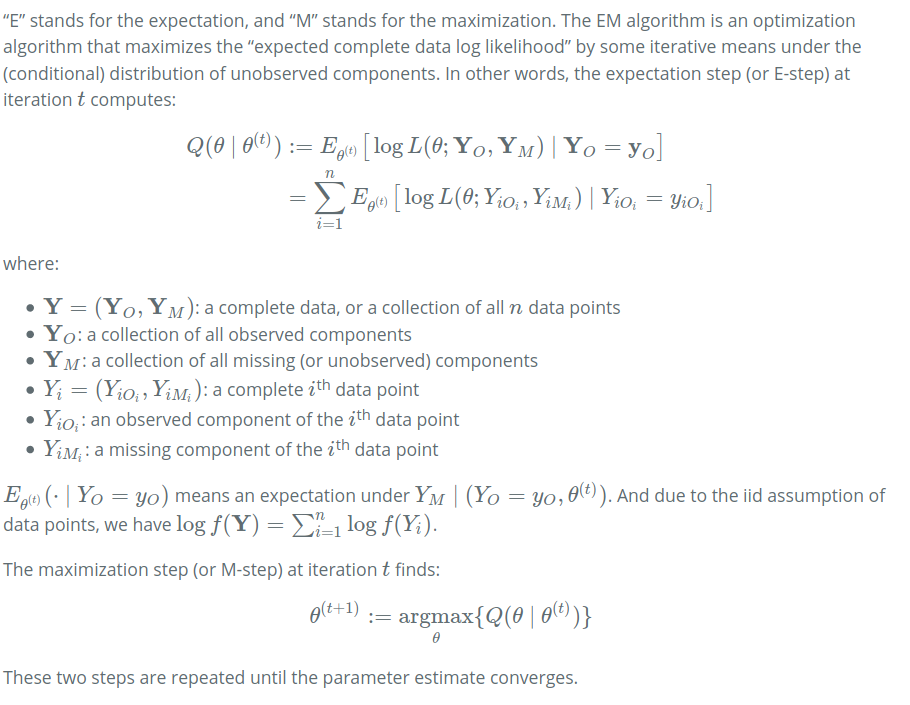

In [18]:
def impute_em(X, max_iter = 3000, eps = 1e-08):
    '''(np.array, int, number) -> {str: np.array or int}
    
    Precondition: max_iter >= 1 and eps > 0
    
    Return the dictionary with five keys where:
    - Key 'mu' stores the mean estimate of the imputed data.
    - Key 'Sigma' stores the variance estimate of the imputed data.
    - Key 'X_imputed' stores the imputed data that is mutated from X using 
      the EM algorithm.
    - Key 'C' stores the np.array that specifies the original missing entries
      of X.
    - Key 'iteration' stores the number of iteration used to compute
      'X_imputed' based on max_iter and eps specified.
    '''
    
    nr, nc = X.shape
    C = np.isnan(X) == False
    
    # Collect M_i and O_i's
    one_to_nc = np.arange(1, nc + 1, step = 1)
    M = one_to_nc * (C == False) - 1
    O = one_to_nc * C - 1
    
    # Generate Mu_0 and Sigma_0
    Mu = np.nanmean(X, axis = 0)
    observed_rows = np.where(np.isnan(sum(X.T)) == False)[0]
    S = np.cov(X[observed_rows, ].T)
    if np.isnan(S).any():
        S = np.diag(np.nanvar(X, axis = 0))
    
    # Start updating
    Mu_tilde, S_tilde = {}, {}
    X_tilde = X.copy()
    no_conv = True
    iteration = 0
    while no_conv and iteration < max_iter:
        for i in range(nr):
            S_tilde[i] = np.zeros(nc ** 2).reshape(nc, nc)
            if set(O[i, ]) != set(one_to_nc - 1): # missing component exists
                M_i, O_i = M[i, ][M[i, ] != -1], O[i, ][O[i, ] != -1]
                S_MM = S[np.ix_(M_i, M_i)]
                S_MO = S[np.ix_(M_i, O_i)]
                S_OM = S_MO.T
                S_OO = S[np.ix_(O_i, O_i)]
                Mu_tilde[i] = Mu[np.ix_(M_i)] +\
                    S_MO @ np.linalg.inv(S_OO) @\
                    (X_tilde[i, O_i] - Mu[np.ix_(O_i)])
                X_tilde[i, M_i] = Mu_tilde[i]
                S_MM_O = S_MM - S_MO @ np.linalg.inv(S_OO) @ S_OM
                S_tilde[i][np.ix_(M_i, M_i)] = S_MM_O
        Mu_new = np.mean(X_tilde, axis = 0)
        S_new = np.cov(X_tilde.T, bias = 1) +\
            reduce(np.add, S_tilde.values()) / nr
        no_conv =\
            np.linalg.norm(Mu - Mu_new) >= eps or\
            np.linalg.norm(S - S_new, ord = 2) >= eps
        Mu = Mu_new
        S = S_new
        iteration += 1
    
    result = {
        'mu': Mu,
        'Sigma': S,
        'X_imputed': X_tilde,
        'C': C,
        'iteration': iteration
    }
    
    return result

In [19]:
np.random.seed(1024)
mu = np.array([1, 2, 6])
Sigma = np.array([[118, 62, 44], [62, 49, 17], [44, 17, 21]])
n = 400
X_truth = np.random.multivariate_normal(mu, Sigma, n)

result = simulate_nan(X_truth, nan_rate = .4)
X = result['X'].copy()

result_imputed = impute_em(X)

result_imputed['X_imputed'][np.arange(0, 9), ] # imputed data

array([[-22.51504305, -11.93399968,  -2.38998182],
       [ -4.13801604,  -1.45747717,   4.38246185],
       [ -6.96117925,  -4.78845229,   1.21653198],
       [  6.57201047,   6.0520226 ,   8.87408451],
       [  7.27634923,   4.25868765,   9.17663177],
       [  1.20775573,   1.51178112,   6.38217986],
       [ -6.74901264,  -5.44848469,   4.44208904],
       [ -4.17891721,  -3.48215875,   4.29849034],
       [-11.29647092,   1.28621915,  -0.84012076]])

In [20]:
X_truth[np.arange(0, 9), ] # truth

array([[-22.51504305, -11.21931542,  -0.31680441],
       [ -4.13801604,  -3.3813311 ,   3.97850866],
       [ -6.96117925,  -4.78845229,   1.21653198],
       [  6.57201047,   6.0520226 ,   8.87408451],
       [  8.07906102,   3.46018924,   9.17663177],
       [ -2.71777693,   1.51178112,   4.17435875],
       [ -5.25896933,  -5.44848469,   4.44208904],
       [ -4.17891721,  -3.48215875,   4.29849034],
       [-11.29647092,   1.28621915,   0.98402706]])

## References

1. https://www.numpyninja.com/post/how-to-implement-mice-algorithm-using-iterative-imputer-to-handle-missing-values
2. https://www.numpyninja.com/post/mice-algorithm-to-impute-missing-values-in-a-dataset
3. https://www.kaggle.com/lmorgan95/missforest-the-best-imputation-algorithm
4. https://joon3216.github.io/research_materials/2019/em_imputation_python.html#comparison-with-the-r-function
5. https://joon3216.github.io/research_materials/2019/em_imputation.html
6. https://rmisstastic.netlify.app/how-to/python/howtoimpute